# Implementing the SPT Model

Allen Pinjic - Created on June 6th, 2022

In [1]:
from astropy.io.fits import getdata
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo

In [2]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import pylab as plt
import pymc3 as pm
import aesara
import matplotlib.font_manager
import scipy.stats
import scipy.optimize
import math

In [3]:
%matplotlib inline

## Retrieving SPT Data

In [4]:
fname = '../data_set/sptecs_catalog_oct919.fits'

data = Table(getdata(fname))

In [5]:
df = data.to_pandas()
h=0.7
df['log_M500'] = np.log(df.M500*1e14*h)
df['log_LAMBDA_CHISQ'] = np.log(df.LAMBDA_CHISQ)

/usr/local/anaconda/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
## Calculating the log of the mean mass error ##
m500 = df.M500.to_numpy()*1e14*h
log_m500 = np.log(m500)

lerr = df.M500_LERR.to_numpy()*1e14*h
uerr = df.M500_UERR.to_numpy()*1e14*h

m500_err = (lerr+uerr)/2 # mean mass error
log_m500_err = m500_err/m500

# Eliminating NaN values from the log_m500_err data set
nnan = ~np.isnan(log_m500_err)
nnan2 = ~np.isnan(log_m500)

<ipython-input-6-5c4766f6076c>:3: RuntimeWarning: divide by zero encountered in log
  log_m500 = np.log(m500)
<ipython-input-6-5c4766f6076c>:9: RuntimeWarning: invalid value encountered in true_divide
  log_m500_err = m500_err/m500


In [7]:
## Calculating the log of the richness error ##

lbd = df.LAMBDA_CHISQ.to_numpy()
lbd_err = df.LAMBDA_CHISQ_E.to_numpy()

log_lbd = df.log_LAMBDA_CHISQ
log_lbd_err = lbd_err/lbd

# Eliminating NaN values from the log_lbd_err data set
nnan3 = ~np.isnan(log_lbd_err)
nnan4 = ~np.isnan(log_lbd)

nnan_all = nnan & nnan2 & nnan3 & nnan4

<ipython-input-7-949632b44be5>:7: RuntimeWarning: invalid value encountered in true_divide
  log_lbd_err = lbd_err/lbd


In [8]:
df0 = df
z = df0.REDSHIFT.to_numpy()
lbd = df0.LAMBDA_CHISQ.to_numpy()
zcut = (z > 0.1) & (z < 0.65)
lcut = lbd > 20
final_cut = zcut & lcut

In [9]:
df = df0.loc[final_cut].copy()

## First Draft Version

In [10]:
#Y = np.vstack([x,y])

In [11]:
def model(theta, x, gammasz = 1.0, M0 = 3e14, Ez0=1.):
    M, z  = x
    asz, bsz, csz, albd, blbd, clbd, = theta

    y1 = gammasz*asz + bsz*np.log(M/M0) + csz*np.log(E(z)/Ez0)
    y2 = albd + albd*np.log(M/M0) + clbd*np.log(E(z)/Ez0)
    return np.vstack([y1,y2])
    

In [12]:
from colossus.cosmology import cosmology
from colossus.lss import mass_function
from astropy.io.fits import getdata
from astropy.table import Table
cosmology.setCosmology('WMAP9')

# true = obs lambda
# true SZ signal = obs SZ signal

def joint_probability(y1, y2, mu1, mu2, s1, s2, rho):
    den = 2*np.pi*s1*s2*np.sqrt(1-rho**2)
    num = (y1-mu1)**2/s1**2 + (y2-mu2)**2/s2**2
    num += 2*((y1-mu1)/s1)*((y2-mu2)/s2)/(2*(1-rho**2))
    log_prob = -num/(2*(1-rho**2))
    prob = np.exp(log_prob/den)
    return prob

def prob_lbd_sz(theta, M, z):
    y1, y2 = y[0], y[1]
    
    # covariance
    s1, s2, rho = theta[-3], theta[-2], theta[-1]
    
    # predictions
    mu1, mu2 = model(theta, x)
    
    #joint probability
    return joint_probability(y1, y2, mu1, mu2, s1, s2, rho)


#comparing predictions with the model

# x = M, z
def hal0_mass_function(M, z):
    return mass_function.massFunction(M, z, mdef = 'vir', model = 'tinker08')


def prob_obs_lambda_integrand(M, z, theta):
    M, z = x
    prob = prob_lbd_sz(theta, x, y)
    hmf = halo_mass_function(M, z)
    integrand = prob*hmf
    return integrand

def prob_obs_lambda(theta, x, y, errors, Norm=1.):
    M, z = x
    value = scipy.integrated.quad(prob_obs_lambda_integrand, 1e13, 1e16, args=(z, theta, y))/Norm
    return value

def log_likelihood(theta, x, y, errors):
    return np.log(prob_obs_lambda(theta, x, y, errors))

## Solving for the Model Directly (via S. Grandis et al. 2021)

In [13]:
## Lisiting constants (or undefined variables for now too) ##

M0 = 3e14

M = log_m500[nnan_all]
# Is M defined as simply the values of the mass or the log of the mass?

z = z[nnan_all]

lbd = log_lbd[nnan_all]
# Is lbd defined as simply the values of lambda or the log of lambda?

lbd_error = log_lbd_err[nnan_all]
# Is lbd_error defined as simply the error values of lambda or the error values of the log of lambda?

chsi = 0
lbd_hat = 0
rho = 0
zeta = 0
scatter_lambda = 0
scatter_zeta = 0
# Temporary values (since they are unknown as of yet)

In [14]:
def E(z):
    # The Hubble constant at the value of z
    Hz = cosmo.H(z).value
    # The Hubble constant at z=0
    H0 = cosmo.H(0).value
    return (Hz/H0)

In [15]:
A_lambda = 76.9
B_lambda = 1.020
C_lambda = 0.29
scatter_lambda = 0.16

#A_lambda = pm.Normal("A_lambda", mu=76.9, sigma=(8.2*3))
#B_lambda = pm.Normal("B_lambda", mu=1.020, sigma=(0.080*3))
#C_lambda = pm.Normal("C_lambda", mu=0.29, sigma=(0.27*3))
#scatter_lambda = pm.HalfCauchy("scatter", 0.16)

A_sze = 5.24
B_sze = 1.534
C_sze = 0.465
scatter_sze = 0.161

#A_lambda = pm.Normal("A_lambda", mu=5.24, sigma=(0.85*3))
#B_lambda = pm.Normal("B_lambda", mu=1.534, sigma=(0.100*3))
#C_lambda = pm.Normal("C_lambda", mu=0.465, sigma=(0.407*3))
#scatter_sze = pm.HalfCauchy("scatter", 0.080)


## Not sure whether to use point values or values on a distribution ##

In [121]:
from colossus.cosmology import cosmology
from colossus.lss import mass_function
cosmology.setCosmology('WMAP9')

def _halo_mass_function(M, z):
    return mass_function.massFunction(M, z, mdef = 'vir', model = 'tinker08')
halo_mass_function = np.vectorize(_halo_mass_function)

def E(z):
    # The Hubble constant at the value of z
    Hz = cosmo.H(z).value
    # The Hubble constant at z=0
    H0 = cosmo.H(0).value
    return (Hz/H0)

In [17]:
M0 = 3e14
Ez0 = E(0)

def ln_lbd_given_M(theta_lambda,lnM,z):
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta_lambda
    return np.log(A_lambda) + (B_lambda)*lnM + (C_lambda)*(np.log(E(z)/Ez0))

def ln_zeta_given_M(theta_sze,lnM,z):
    A_sze, B_sze, C_sze, scatter_sze = theta_sze
    return np.log(A_sze) + (B_sze)*lnM + (C_sze)*(np.log(E(z)/Ez0))

In [130]:
from scipy.integrate import simps

# given: mvec, lbdvec and zetavec

def log_likelihood(theta, z, y, yerr, eps=1e-9):
    # defining variables
    lbd_hat, chisi = y[0], y[1]
    lbd_error = yerr
    nsize = len(lbd_hat)
    
    # unfolding theta
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_zeta = theta[:4]
    rho = theta[-1]
    
    # setting grid for integration
    mm, zz = np.meshgrid(mvec, z)
    mm2 = np.exp(mm)*M0
    
    # normalization factor
    mm, zz = np.meshgrid(mvec, z)
    
    # calling predictions; 
    ln_lbd_pred = (ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda],mm,zz)).T
    ln_zeta_pred= (ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze],mm,zz)).T
    
    halo_mass_func = (halo_mass_function(mm2, zz)*mm2).T
    
    # integrating over zeta, lambda
    prob_lbd_hat = marginalize_over_lbd_zeta(lbd_hat, chisi, ln_lbd_pred, ln_zeta_pred, halo_mass_func,
                                             scatter_lambda, scatter_zeta, rho)
    # normalization factor
    norm = marginalize_over_lbd_zeta(lbdhatvec, chisi, ln_lbd_pred, ln_zeta_pred, halo_mass_func,
                                     scatter_lambda, scatter_zeta, rho)
    prob = prob_lbd_hat/norm
    log_prob = np.log(prob)
    return np.sum(log_prob)

def marginalize_over_lbd_zeta(lbd_hat, chisi, ln_lbd_pred, ln_zeta_pred, halo_mass_func,
                              scatter_lambda, scatter_zeta, rho):
    # integrating over zeta, lambda
    res_zeta = np.full((zetavec.size, nsize),-np.inf,dtype=float)
    res_lbd = np.full((lbdvec.size, nsize),-np.inf,dtype=float)

    for j,lbd in enumerate(lbdvec):
        for i,zeta in enumerate(zetavec):
            dn_dlbd_dzeta = compute_dn_dlbd_dzeta(lbd, zeta, lbd_hat, chisi, ln_lbd_pred, ln_zeta_pred, halo_mass_func,
                                                  scatter_lambda, scatter_zeta, rho)
            res_zeta[i] = dn_dlbd_dzeta/np.max(dn_dlbd_dzeta)
        if j==1:
            res_zeta_to = res_zeta
        # integrate over zeta for a given lambda
        res_lbd[j] = simps(res_zeta, x=zetavec, axis=0)
    # integrate over lambda
    prob = simps(res_lbd, x=lbdvec, axis=0)
    return prob

## likelihood including the errors
def compute_dn_dlbd_dzeta(lbd, zeta, lbd_hat, chisi, ln_lbd_pred, ln_zeta_pred, halo_mass_func,
                          scatter_lambda, scatter_zeta, rho):
    # input
    # lbd, zeta, scatter_lbd/zeta and rho: float: numbers
    # ln_lbd/zeta_pred; halo_mass_func are nsize x msize vectors
    # output: nsize array
    s_lambda = np.sqrt((scatter_lambda)**2 + (lbd-1)/lbd**2)#np.std(lbd_hat) #np.sqrt(scatter_lambda** + 1/lbd**2)
    s_zeta = scatter_zeta

    # avoid error messages
    rho_inv = (1-rho**2)
    rho_inv = np.where(rho_inv<=eps, -np.inf, 1/rho_inv)

    # defining standirized variables
    lbd_std = (lbd - ln_lbd_pred)/s_lambda
    zeta_std = (zeta - ln_zeta_pred)/s_zeta

    # lbd_likelihood
    lp_lbd  = -rho_inv*lbd_std**2/2 - ((lbd-lbd_hat)/lbd_err)**2/2.

    # zeta likelihood
    lp_zeta = -rho_inv*zeta_std**2/2 -(chisi-np.sqrt(zeta**2+3))**2/2.

    # corr likelihod
    lp_corr = rho*rho_inv*lbd_std*zeta_std

    # debuging here
    lp_total_m = lp_lbd+lp_zeta+lp_corr

    p_total_m = np.exp(lp_total_m)*halo_mass_func

    # integrate over M
    lp_total = simps(p_total_m, x=mvec, axis=0)
    
    return lp_total

### Debugging

In [19]:
theta = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]

# unfolding theta
A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
A_sze, B_sze, C_sze, scatter_zeta = theta[:4]
rho = theta[-1]

print(A_lambda, B_lambda, C_lambda, scatter_lambda)
print(A_sze, B_sze, C_sze, scatter_sze)
print(rho)

print('The first lines of log_likelihood works')

76.9 1.02 0.29 0.16
5.24 1.534 0.465 0.161
0.8
The first lines of log_likelihood works


In [20]:
data = Table(getdata(fname))
data[:2]

SPT_ID,RA,DEC,FIELD,XI,THETA_CORE,REDSHIFT,REDSHIFT_UNC,SPECZ,REDSHIFT_SOURCE,RM_PROB,CL_NOTES,M500,M500_UERR,M500_LERR,LAMBDA_CHISQ,LAMBDA_CHISQ_E,RADIO_CONTAM,STRONG_LENS,IMAGE_SOURCE,SPECZ_REF,STRONG_LENS_REF,PHOTOMETRIC_ZREF
str16,float64,float64,str11,float32,float32,float32,float32,int16,float32,float32,str50,float32,float32,float32,float32,float32,float32,float32,float32,str38,str19,str29
SPT-CLJ0000-2518,0.072338357,-25.303935,ra1hdec-25,5.073545,1.5,0.0,0.0,0,0.0,0.0,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,,,
SPT-CLJ0005-3751,1.4383179,-37.854369,ra1hdec-35,6.336327,0.75,0.48295808,0.0072415886,0,4.0,0.00061007956,-,5.419,0.887,0.887,86.40839,4.7352147,0.0,1.0,3.0,,,


In [21]:
sz_signal = np.array(data['XI'])
lambda_chisq = np.array(data['LAMBDA_CHISQ'])
lambda_chisqE = np.array(data['LAMBDA_CHISQ_E'])
redshift = np.array(data['REDSHIFT'])

In [22]:
# getting some observational data to debug the code
Np = 10
ix = np.where(lambda_chisq>30)[0][:Np] # take 10 points

z = redshift[ix]
chisi = np.log(sz_signal[ix])
lbd_hat = np.log(lambda_chisq[ix])
lbd_err = np.log(lambda_chisqE[ix])

In [126]:
# set up integration vectors
mvec = np.log(np.logspace(13.5, 16, 50)/M0)
lbdvec = np.log(np.linspace(5., 1.5*np.max(lambda_chisq), 50))
lbdhatvec = np.log(np.linspace(40., 3*np.max(lambda_chisq), 50))
zetavec = np.log(np.linspace(1., 1.3*np.max(sz_signal), 50))

print('Vector size')
print(mvec.size)
print(lbdvec.size)
print(zetavec.size)

Vector size
50
50
50


In [61]:
# setting grid for integration
mm, zz = np.meshgrid(mvec, z)
mm2, zz = np.meshgrid(np.exp(mvec)*M0, z)
lbd_hatt, ll = np.meshgrid(lbd_hat, lbdvec)

# calling predictions; 
ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda],mm,zz).T
ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze],mm,zz).T

# need to implement an interpolation scheme
# for now try np.vectorize(halo_mass_function)
halo_mass_function2 = np.vectorize(halo_mass_function)
halo_mass_func = (halo_mass_function2(mm2, zz)*mm2) .T

print('ln_lbd_pred shape:',ln_lbd_pred.shape)
print('ln_zeta_pred shape:',ln_zeta_pred.shape)
print('halo_mass_func shape:',halo_mass_func.shape)
print('Lambda predictions as a function of mass for the first object')
np.exp(ln_lbd_pred[:,0])
# halo_mass_func[:,0]

ln_lbd_pred shape: (50, 10)
ln_zeta_pred shape: (50, 10)
halo_mass_func shape: (50, 10)
Lambda predictions as a function of mass for the first object


array([   8.3316037 ,    9.39224517,   10.5879099 ,   11.93578682,
         13.45525305,   15.16815249,   17.09910985,   19.27588465,
         21.72977027,   24.49604388,   27.61447352,   31.12988985,
         35.09283063,   39.56026723,   44.5964237 ,   50.27370001,
         56.67371288,   63.88846914,   72.0216884 ,   81.19029411,
         91.52609448,  103.17767737,  116.31254636,  131.11952882,
        147.81149046,  166.62839555,  187.84075662,  211.75352333,
        238.71046653,  269.0991202 ,  303.35635277,  341.97464747,
        385.50918234,  434.58581145,  489.91006225,  552.27727819,
        622.58405269,  701.84111852,  791.18787821,  891.90878406,
       1005.45180353, 1133.44923527, 1277.74117509, 1440.40196925,
       1623.77003532, 1830.4814794 , 2063.50799285, 2326.19957343,
       2622.33268501, 2956.16454814])

In [62]:
# simps(halo_mass_function2(mvec,0.1)*mvec,x=np.log(mvec/M0))

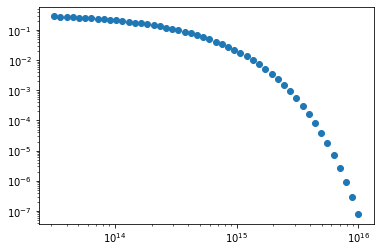

In [63]:
plt.scatter(mm2[0],halo_mass_function2(mm2[0],0.))
# plt.scatter(mvec/M0,halo_mass_function2(mvec,0.1))
plt.xscale('log')
plt.yscale('log')

In [64]:
# halo_mass_func

In [65]:
# test function 
# debuging here
eps  =1e-9
lbd  = np.mean(lbd_hat)
zeta = np.mean(chisi)
dn_dlbd_dzeta = compute_dn_dlbd_dzeta(lbd, zeta, ln_lbd_pred, ln_zeta_pred, halo_mass_func,
                                      scatter_lambda, scatter_zeta, rho)

print('dn_dlbd_dzeta shape:',dn_dlbd_dzeta.shape)
print(dn_dlbd_dzeta)

dn_dlbd_dzeta shape: (10,)
[1.49864954e+12 3.37182944e+12 6.37409728e+11 8.20822716e+11
 3.90124629e+12 6.43918086e+11 4.31870211e+12 3.06864704e+12
 3.04336152e+12 1.29791575e+12]


In [66]:
# input
# lbd, zeta, scatter_lbd/zeta and rho: float: numbers
# ln_lbd/zeta_pred; halo_mass_func are nsize x msize vectors
# output: nsize array
s_lambda = np.sqrt((scatter_lambda)**2 + (lbd-1)/lbd**2)#np.std(lbd_hat) #np.sqrt(scatter_lambda** + 1/lbd**2)
s_zeta = scatter_zeta

# avoid error messages
rho_inv = (1-rho**2)
rho_inv = np.where(rho_inv<=eps, -np.inf, 1/rho_inv)

# defining standirized variables
lbd_std = (lbd - ln_lbd_pred)/s_lambda
zeta_std = (zeta - ln_zeta_pred)/s_zeta

# print(np.exp(ln_lbd_pred[:,0]))
print(lbd_std[:,2])

[ 5.38452353  5.11467845  4.84483337  4.57498829  4.30514321  4.03529813
  3.76545306  3.49560798  3.2257629   2.95591782  2.68607274  2.41622767
  2.14638259  1.87653751  1.60669243  1.33684735  1.06700227  0.7971572
  0.52731212  0.25746704 -0.01237804 -0.28222312 -0.5520682  -0.82191327
 -1.09175835 -1.36160343 -1.63144851 -1.90129359 -2.17113866 -2.44098374
 -2.71082882 -2.9806739  -3.25051898 -3.52036406 -3.79020913 -4.06005421
 -4.32989929 -4.59974437 -4.86958945 -5.13943452 -5.4092796  -5.67912468
 -5.94896976 -6.21881484 -6.48865992 -6.75850499 -7.02835007 -7.29819515
 -7.56804023 -7.83788531]


In [67]:
# ln_lbd_pred

In [68]:
# lbd_likelihood
lp_lbd  = -rho_inv*lbd_std**2/2 - ((lbd-lbd_hat)/lbd_err)**2/2.

# zeta likelihood
lp_zeta = -rho_inv*zeta_std**2/2 -(chisi-np.sqrt(zeta**2+3))**2/2.

# corr likelihod
lp_corr = rho*rho_inv*lbd_std*zeta_std

# debuging here
lp_total_m = lp_lbd+lp_zeta+lp_corr

p_total_m = np.exp(lp_total_m)*halo_mass_func

# integrate over M
lp_total = simps(p_total_m, x=mvec, axis=0)

In [69]:
lp_total

array([1.49864954e+12, 3.37182944e+12, 6.37409728e+11, 8.20822716e+11,
       3.90124629e+12, 6.43918086e+11, 4.31870211e+12, 3.06864704e+12,
       3.04336152e+12, 1.29791575e+12])

In [119]:
# integrating over zeta, lambda
nsize = Np
res_zeta = np.full((zetavec.size, nsize),-np.inf,dtype=float)
res_lbd = np.full((lbdvec.size, nsize),-np.inf,dtype=float)

for j,lbd in enumerate(lbdvec):
    for i,zeta in enumerate(zetavec):
        dn_dlbd_dzeta = compute_dn_dlbd_dzeta(lbd, zeta, ln_lbd_pred, ln_zeta_pred, halo_mass_func,
                                              scatter_lambda, scatter_zeta, rho)
        res_zeta[i] = dn_dlbd_dzeta/np.max(dn_dlbd_dzeta)
    if j==1:
        res_zeta_to = res_zeta
    # integrate over zeta for a given lambda
    res_lbd[j] = simps(res_zeta, x=zetavec, axis=0)
# integrate over lambda
prob = simps(res_lbd, x=lbdvec, axis=0)
ln_prob = np.log(prob)


In [131]:
## computing normalization factor
# build lbd_hat going over all the indices

# integrating over zeta, lambda
prob_lbd_hat = marginalize_over_lbd_zeta(lbd_hat, chisi, ln_lbd_pred, ln_zeta_pred, halo_mass_func,
                                         scatter_lambda, scatter_zeta, rho)
# normalization factor
norm = marginalize_over_lbd_zeta(lbdhatvec, chisi, ln_lbd_pred, ln_zeta_pred, halo_mass_func,
                                 scatter_lambda, scatter_zeta, rho)
prob = prob_lbd_hat/norm
log_prob = np.log(prob)


lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()

lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()

lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()

lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()

lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shap

lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shap

lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shap

lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shap

lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shap

lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shap

lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (10,)
lbd_err.shape (10,)
lbd.shape ()
lbd_std.shape (50, 10)
lbd_hat.shape (50,)
lbd_err.shape (10,)


ValueError: operands could not be broadcast together with shapes (50,) (10,) 

In [18]:
def log_likelihood_lambda():
    equationPt1 = (1/((-2)*(1 - (rho)**2)))*[((lbd - ln_lbd_given_M)/(scatter_lambda))**2 
                + (-2)*(rho)*((lbd - ln_lbd_given_M)/(scatter_lambda))]
    equationPt2 = (-1/2)*((lbd - lbd_hat)/lbd_error)**2
    return (equationPt1) + (equationPt2)

def log_likelihood_zeta():
    eq1 = (chsi - math.sqrt((zeta)**2 + 3))**2
    eq2 = ((zeta - ln_zeta_given_M)/(scatter_zeta))**2
    return (eq1 + eq2)
    
def log_likelihood_correlation():
    equation = (-2*rho)*((lbd - ln_lbd_given_M)/(scatter_lambda))*((zeta - ln_zeta_given_M)/(scatter_zeta))
    return equation
    
def log_likelihood_total():
    return (log_likelihood_lambda + log_likelihood_zeta + log_likelihood_correlation + np.log(hal0_mass_function(M, z)))
